# Task
    Propose a PyTorch nn.Module that functions as a power equation: 

    y=x^n

    The parameter n should be learnable and constrained to values in the range [1, 3]. The outputs from the nn.Module forward method should always be positive. Prepare a Jupyter notebook to demonstrate the use of this nn.Module on a random valued batched vector (torch.tensor) with dimensions 8x16.

In [363]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Union, Iterable

from utils.utils import set_random_seed


with open('config.yaml') as yf:
    config = yaml.safe_load(yf)

set_random_seed(config['SEED'])

In [364]:
class VectorPower(object):
    def __init__(self, power: Union[float, int] = config['N_POWER'], product_type: str = config['PRODUCT_TYPE']) -> None:
        if product_type not in ['element-wise and sum', 'element-wise']:
            raise ValueError(f'Passed product_type ({product_type}) is not supported. Please choose from "element-wise and sum", "element-wise".')
        
        self.power = power
        self.product_type = product_type

    def __call__(self, x: Iterable) -> torch.Tensor:
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x)
            
        if self.product_type == 'element-wise and sum':
            return torch.sum(self.element_wise_product(x))
        elif self.product_type == 'element-wise':
            return self.element_wise_product(x)
    
    def element_wise_product(self, x: torch.Tensor) -> torch.Tensor:
        return torch.pow(x, self.power)
    
    def set_power(self, power: float) -> None:
        self.power = power


class PowerModule(nn.Module):
    def __init__(self, vector_power: VectorPower) -> None:
        super(PowerModule, self).__init__()
        self.vp = vector_power
        self.n_param = nn.Parameter(torch.rand(1))
        # bound power parameter to [0, 3] using sigmoid function
        self.n = 3 * torch.sigmoid(self.n_param)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if len(x.shape) != 2:
            raise ValueError(f'Input shape must be 2D. Got {len(x.shape)}D.')
        
        self.n = 3 * torch.sigmoid(self.n_param)
        self.vp.set_power(self.n)
        y = torch.stack([self.vp(x_i) for x_i in x], dim=0)
        return y
    
def optimizing(
    pm: PowerModule,
    batch_x: torch.Tensor,
    batch_y: torch.Tensor,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer, 
    loss: float = np.inf, 
    epoch: int = 0,
    n_param_true: Union[float, int] = config["N_POWER"]) -> None:
    while loss > float(config['ERROR_RATE']):
        epoch += 1
        batch_y_hat = pm(batch_x)
        loss = criterion(batch_y_hat, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f'Epoch: {epoch}')
        print('Loss: ', loss.item())
        print('Updated n_param: ', pm.n.item())
        print('-----------------')
    else:
        plt.figure(figsize=(10, 10))
        if len(batch_y.shape) == 2:
            print('Target coordinates: ', batch_y)
            print('Output coordinates: ', batch_y_hat.detach().numpy())
            plt.plot(np.sum(batch_y_hat.detach().numpy(), axis=1), label='output')
            plt.plot(np.sum(batch_y.numpy(), axis=1), label='target')
            plt.ylabel('target coordinates sum value')
        else:
            plt.plot(batch_y_hat.detach().numpy(), label='output')
            plt.plot(batch_y.numpy(), label='target')
            plt.ylabel('target value')
        plt.legend()
        plt.title(f'n_param: {pm.n.item()}, n_param_true: {n_param_true}')
        plt.xlabel('batch_index')
        plt.show()

## Vector powering problem
According to task description, our goal is to approximate function 
$$y = x^n$$
, where x is vector and n is unknown parameter.

We can translate this task into $y = x * x * ... (n-times) ... * x$. In such case, we need to define what vector product is mean in this situanion. We have next options:
 - vector (geometrical or cross) product:
   - result of vector product is also vector, but direct classic formula is designed only for 3 dimensional vectors (we have 16 in our case).
   - There exist generalisation of vector product to (higher space)[https://en.wikipedia.org/wiki/Cross_product#Generalizations]
   - in this case n should to be int value, but pytorch for training use float number, to perform powering, we first need to round n and the perform some steps of powering, this rounding prodecure is not differentiable
 - dot product:
    - here n is int value
    - as n take only values [1, 2, 3], for each case we have own formula:
        - n = 1: identical ouput
        - n = 2: dot product of x and x
        - n = 3: scalar triple dot product. Triple scalar product formula has cross product in it, so it brings all it disadvantages
    - summing up dot and cross product is not best choice of representiong this task
 - simple element-wise powering of each vector coordinate:
    - here n can be any float number
    - input vector has to have only non-negative values to perfome powering to float number
    - to compute function, we just power each element of vector
    - here y as output can stay a vector, then to suit task obligation, y need to be positive vector, that mean it has to have all coordinates positive. As we only use positive input vector, this condition is following.
    - here y as output can be a scalar if we add some aggregation function, for instance, it will be sum, but can be change to any preferable

To suit correct parameter I will be using simple optimization algorythm based on Gradient Descent with stoping on achieving affordable error between real and predicted values.



### Element-wise
Sum aggregation element-wise implementation:

Input batch of vectors shape:  torch.Size([8, 16])
Input vector example: 
tensor([0.4342, 0.5351, 0.8302, 0.1239, 0.0293, 0.5494, 0.3825, 0.5463, 0.4683,
        0.0172, 0.0214, 0.3664, 0.2054, 0.1923, 0.3543, 0.2179])
Target of power operration: 
tensor([2.0139, 2.7882, 5.1336, 5.1991, 2.5463, 4.8078, 4.7104, 3.0989])
Epoch: 1
Loss:  1.1921550035476685
Updated n_param:  1.7007193565368652
-----------------
Epoch: 2
Loss:  0.8900315165519714
Updated n_param:  1.7741687297821045
-----------------
Epoch: 3
Loss:  0.5123019218444824
Updated n_param:  1.8958808183670044
-----------------
Epoch: 4
Loss:  0.2287612110376358
Updated n_param:  2.0361690521240234
-----------------
Epoch: 5
Loss:  0.07298171520233154
Updated n_param:  2.1721339225769043
-----------------
Epoch: 6
Loss:  0.01059300173074007
Updated n_param:  2.2915053367614746
-----------------
Epoch: 7
Loss:  0.0006768458406440914
Updated n_param:  2.3904929161071777
-----------------
Epoch: 8
Loss:  0.015332190319895744
Updated

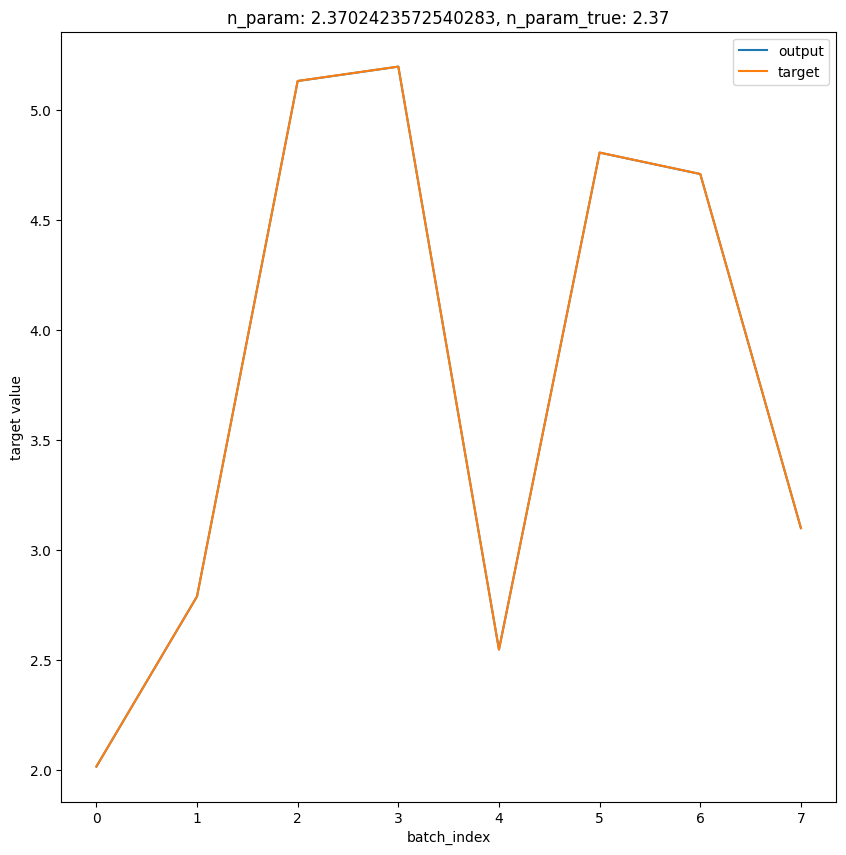

In [365]:
# generate only positive data points to avoid nan and follow the conditions
batch_x = torch.rand(8, 16).abs()
print('Input batch of vectors shape: ', batch_x.shape)
print('Input vector example: ', batch_x[0], sep='\n')

vp = VectorPower(product_type='element-wise and sum')
batch_y = torch.stack([vp(el) for el in batch_x])
print('Target of power operration: ', batch_y, sep='\n')

pm = PowerModule(vp)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(pm.parameters(), lr=0.03, momentum=0.9)

optimizing(pm, batch_x, batch_y, criterion, optimizer)

Just element-wise implementation with vector ouput:

Input batch of vectors shape:  torch.Size([8, 16])
Input vector example: 
tensor([0.1510, 0.0182, 0.1681, 0.6722, 0.0483, 0.6568, 0.5558, 0.2432, 0.7911,
        0.5242, 0.6310, 0.0962, 0.3618, 0.5136, 0.6393, 0.4931])
Target of power operration: 
tensor([[1.1332e-02, 7.5474e-05, 1.4603e-02, 3.9014e-01, 7.6103e-04, 3.6918e-01,
         2.4853e-01, 3.5057e-02, 5.7392e-01, 2.1636e-01, 3.3579e-01, 3.8894e-03,
         8.9849e-02, 2.0612e-01, 3.4630e-01, 1.8716e-01],
        [4.7093e-01, 2.3293e-02, 4.1687e-02, 1.7244e-02, 1.8927e-01, 8.3029e-01,
         5.2679e-01, 5.5887e-01, 4.8611e-03, 1.0196e-01, 3.5866e-02, 9.5653e-01,
         6.1100e-01, 1.4288e-01, 1.9494e-01, 9.4260e-02],
        [8.8148e-04, 6.1640e-01, 8.3717e-01, 2.6933e-02, 4.8877e-01, 1.2560e-01,
         5.5890e-04, 1.2385e-02, 3.7386e-03, 6.7164e-01, 2.3652e-01, 1.4790e-03,
         8.2770e-02, 1.7005e-02, 3.5774e-04, 6.6928e-01],
        [7.7148e-03, 6.7754e-01, 1.7163e-01, 4.1974e-05, 6.7422e-04, 7.2914e-01,
         1.

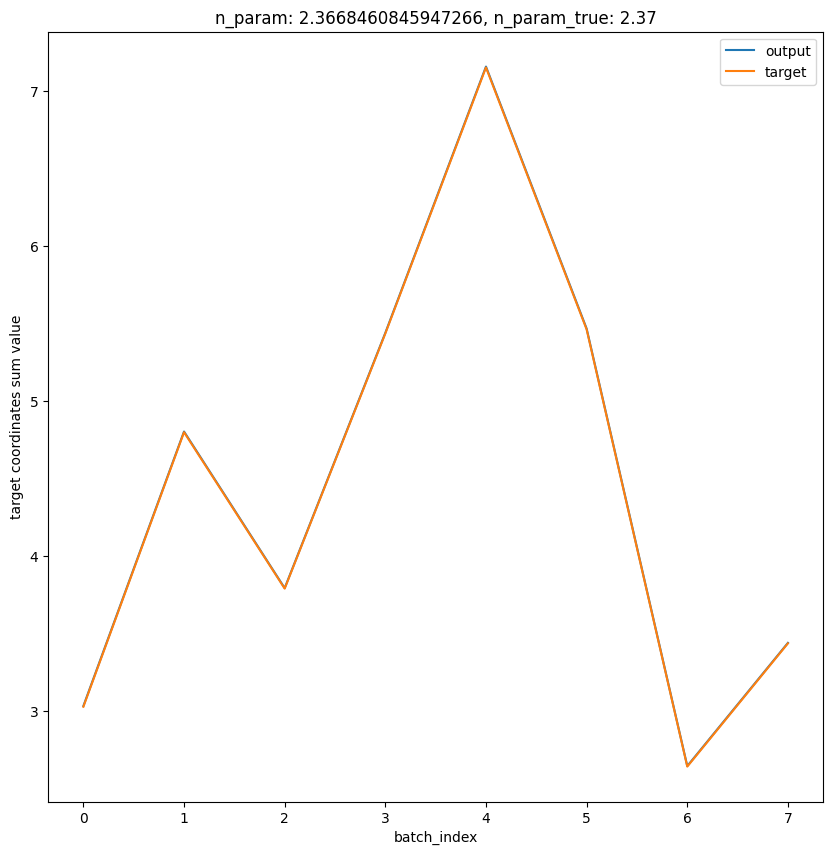

In [366]:
# generate only positive data points to avoid nan and follow the conditions
batch_x = torch.rand(8, 16).abs()
print('Input batch of vectors shape: ', batch_x.shape)
print('Input vector example: ', batch_x[0], sep='\n')

vp = VectorPower(product_type='element-wise')
batch_y = torch.stack([vp(el) for el in batch_x])
print('Target of power operration: ', batch_y, sep='\n')

pm = PowerModule(vp)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(pm.parameters(), lr=0.03, momentum=0.9)

optimizing(pm, batch_x, batch_y, criterion, optimizer)

Obviosly, if set n parametero of ground truth function upper then 3 ( 5 for example), we will never reach optimum, as Module parameter is bounded in range of 1 to 3 according to task condition.

In [367]:
# generate only positive data points to avoid nan and follow the conditions
batch_x = torch.rand(8, 16).abs()
print('Input batch of vectors shape: ', batch_x.shape)
print('Input vector example: ', batch_x[0], sep='\n')

vp = VectorPower(power=5, product_type='element-wise and sum')
batch_y = torch.stack([vp(el) for el in batch_x])
print('Target of power operration: ', batch_y, sep='\n')

pm = PowerModule(vp)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(pm.parameters(), lr=0.03, momentum=0.9)

optimizing(pm, batch_x, batch_y, criterion, optimizer)

Input batch of vectors shape:  torch.Size([8, 16])
Input vector example: 
tensor([0.2621, 0.5537, 0.8355, 0.7213, 0.0896, 0.5920, 0.4298, 0.8120, 0.9308,
        0.9178, 0.2960, 0.9952, 0.0455, 0.1681, 0.8715, 0.7097])
Target of power operration: 
tensor([4.1073, 3.4491, 2.7950, 4.9771, 2.9716, 1.8812, 2.1855, 3.0590])
Epoch: 1
Loss:  6.691240310668945
Updated n_param:  2.1362152099609375
-----------------
Epoch: 2
Loss:  5.928703784942627
Updated n_param:  2.230292320251465
-----------------
Epoch: 3
Loss:  4.90568733215332
Updated n_param:  2.3763363361358643
-----------------
Epoch: 4
Loss:  4.016058444976807
Updated n_param:  2.5283355712890625
-----------------
Epoch: 5
Loss:  3.3757266998291016
Updated n_param:  2.6578121185302734
-----------------
Epoch: 6
Loss:  2.9508965015411377
Updated n_param:  2.756202220916748
-----------------
Epoch: 7
Loss:  2.6764237880706787
Updated n_param:  2.8264739513397217
-----------------
Epoch: 8
Loss:  2.4989593029022217
Updated n_param:  2.8

KeyboardInterrupt: 